In [1]:
%load_ext autoreload
%autoreload 2

# Simulate the interaction strengths of different sRNA pairs interacting

## Imports

In [2]:
import os
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd

from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.srv.sequence_exploration.sequence_analysis import b_tabulate_mutation_info
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config, expand_config
from synbio_morpher.utils.evolution.evolver import Evolver
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.data.data_format_tools.common import load_multiple_as_list
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import jax
import logging
jax.config.update('jax_platform_name', 'cpu')

jax.devices()



/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/jaxtyping/__init__.py:221: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(
I0000 00:00:1706183489.229228 3206440 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
xla_bridge.py:backends():513: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA INFO
xla_bridge.py:backends():513: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory INFO


[CpuDevice(id=0)]

# Choose sRNA species

In [3]:
fn_EcoCyc = '../data/sRNA/EcoCyc/EcoCyc_regulatory_RNAs.csv'
ecocyc = pd.read_csv(fn_EcoCyc)
fn_RNAInter = os.path.join('..', 'data', 'sRNA', 'RNAInter', 'Download_data_RR.csv')
rnainter = pd.read_csv(fn_RNAInter)
try:
    rnainter = rnainter.drop(columns=['Unnamed: 0'])
except:
    pass


### Write to sRNA

In [4]:
circuit_fasta = os.path.join('data', 'ecocyc.fasta')
circuit_fasta_d = {}
with open(circuit_fasta, 'w') as f:

    for n in list(ecocyc['Common-Name'].unique()):
        circuit_fasta_d[n] = ecocyc[ecocyc['Common-Name'] == n]['Sequence - DNA sequence'].iloc[0]
        f.write('>' + n.replace(' ', '_') + '\n')
        f.write(circuit_fasta_d[n])
        f.write('\n')

In [5]:
config = {
    "experiment": {
        "purpose": "tests",
        "no_visualisations": False,
        "no_numerical": False,
        "debug_mode": False
    },
    "data_path": circuit_fasta,
    "system_type": "RNA",
    "include_prod_deg": False,
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            "outcsvcols": "id1,id2,E,E_norm,subseqDB,Pu1,Pu2"
        }
        # "simulator_kwargs": {
        #     "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull",
        #     "threads": 18,
        #     "n": 1,
        #     "raw_stdout": True
        # }
    },
    "mutations_args": {
        "algorithm": "random",
        "mutation_counts": 0,
        "mutation_nums_within_sequence": [1, 3, 5, 20],
        "mutation_nums_per_position": 1,
        "concurrent_species_to_mutate": "single_species_at_a_time",
        "seed": 0
    },
    "signal": {
        "inputs": [ecocyc['Common-Name'].iloc[0]],
        "outputs": [],
        "function_name": "step_function",
        "function_kwargs": {
            "impulse_center": 1,
            "impulse_halfwidth": 5,
            "target": 2
        }
    },
    "simulation": {
        "dt0": 0.1,
        "t0": 0,
        "t1": 100,
        "tmax": 2000,
        "solver": "diffrax",
        "use_batch_mutations": True,
        "interaction_factor": 1,
        "batch_size": 20000,
        "max_circuits": 60000,
        "device": "cpu",
        "threshold_steady_states": 0.05,
        "use_rate_scaling": True
    },
    "molecular_params_factor": 1,
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    }
}

## Simulate

In [9]:
data_writer = None
config, data_writer = script_preamble(config, data_writer)
config_file = expand_config(config=config)
config_file = prepare_config(config_file)
circuit = construct_circuit_from_cfg(prev_configs=None, config_file=config_file)

len(circuit.model.species)


2925

In [7]:
modeller = CircuitModeller(result_writer=data_writer, config=config_file)
circuits = modeller.batch_circuits(
    circuits=[circuit],
    write_to_subsystem=True, batch_size=config_file['simulation'].get('batch_size', 100),
    methods={
        "compute_interactions": {},
        # "init_circuits": {'batch': True},
        # "simulate_signal_batch": {'ref_circuit': None,
        #                           'batch': True},
        "write_results": {'no_visualisations': config_file['experiment'].get('no_visualisations', True),
                          'no_numerical': config_file['experiment'].get('no_numerical', False)}
    })

circuit_manager.py:batch_circuits():600: 	From 1 circuits, a total of 1 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():607: 		Starting new round of viable circuits (0 - 1 / 1) WARNING
circuit_manager.py:batch_circuits():625: 		Making subcircuits 0 - 1 took 1e-05s WARNING
circuit_manager.py:batch_circuits():631: 	Batching 0 - 20000 circuits (out of 0 - 1 (total: 1)) (Circuits: 0 - 1 of 1) WARNING
circuit_manager.py:run_batch():662: 		Running 1 Subcircuits - ecocyc: compute_interactions WARNING
circuit_manager.py:run_batch():698: 		Method compute_interactions took 389.013948s WARNING
circuit_manager.py:run_batch():662: 		Running 1 Subcircuits - ecocyc: write_results WARNING
circuit_manager.py:run_batch():698: 		Method write_results took 0.000362s WARNING
circuit_manager.py:batch_circuits():645: Single batch: 0:06:29.015728 
Projected time: 389.015728s 
Total time: 0:06:29.015736 WARNING


# Visualise

### Reload saves

In [ ]:
saves = pd.read_csv('data/03_simulate_sRNA_confusion/2024_01_21_234310/tabulated_mutation_info.csv')

In [10]:
# source_dirs = [data_writer.top_write_dir]
# source_dirs = ['data/tests/2023_11_03_104039/']
# source_dirs = ['data/03_simulate_sRNA_confusion/2024_01_21_234310/']
# tables = load_multiple_as_list(inputs_list=source_dirs, load_func=b_tabulate_mutation_info, 
#             data_writer=data_writer)
# saves = pd.concat(tables, axis=0)
# saves['path_to_template_circuit'] = circuit_fasta
# source_dirs

['data/03_simulate_sRNA_confusion/2024_01_21_234310/']

In [11]:
saves

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,index,sample_num,name,interacting,...,eqconstants_74-69,eqconstants_74-70,eqconstants_74-71,eqconstants_74-72,eqconstants_74-73,eqconstants_74-74,num_interacting_diff_to_base_circuit,num_self_interacting_diff_to_base_circuit,num_interacting_ratio_from_mutation_to_base,num_self_interacting_ratio_from_mutation_to_base
0,ecocyc,ref_circuit,0,[],[],data/ecocyc.fasta,0.0,2925.0,ecocyc,[[ 0 1]\n [ 0 2]\n [ 0 4]\n ...\n [71 72]\n...,...,0.000009,0.000002,0.000002,0.000004,0.000002,0.000002,0,0,1.0,1.0


In [13]:
saves = saves.drop(index=np.arange(1, len(saves)))


In [14]:
def get_true_interaction_cols(data: pd.DataFrame, interaction_attr, remove_symmetrical=False, num_species=None) -> list:
    if num_species is None and ('sample_name' in data):
        num_species = len(data['sample_name'].unique())
    elif num_species is None:
        num_species = 3
        logging.warning(f'Assuming that the number of species is {num_species}')
    a = np.triu(np.ones((num_species, num_species)))
    if not remove_symmetrical:
        a += np.tril(np.ones((num_species, num_species)))
    names = list(map(lambda i: interaction_attr + '_' + str(i[0]) + '-' + str(i[1]), np.array(np.where(a > 0)).T))
        
    assert all([n in data.columns for n in names]
               ), f'Interaction info column names were not isolated correctly: {names}'
    return names


def make_symmetrical_matrix_from_sequence(arr, side_length: int):
    """ For a flat 1D array, make a symmetrical 2D matrix filling
    in the upper triangle with the 1D array. """
    i = np.triu(
        np.arange(side_length * side_length).reshape(side_length, side_length))
    ii = i + i.T - np.diag(i.diagonal())
    return arr[ii.flatten()].reshape(side_length, side_length)


In [15]:
slengths = np.array([len(circuit_fasta_d[k]) for k in sorted(circuit_fasta_d.keys())])
e = saves[get_true_interaction_cols(saves, 'energies', num_species=len(
    circuit_fasta_d))].values.squeeze()
e = make_symmetrical_matrix_from_sequence(e, side_length=len(circuit_fasta_d))
e_norm = e / (slengths * np.ones_like(e))

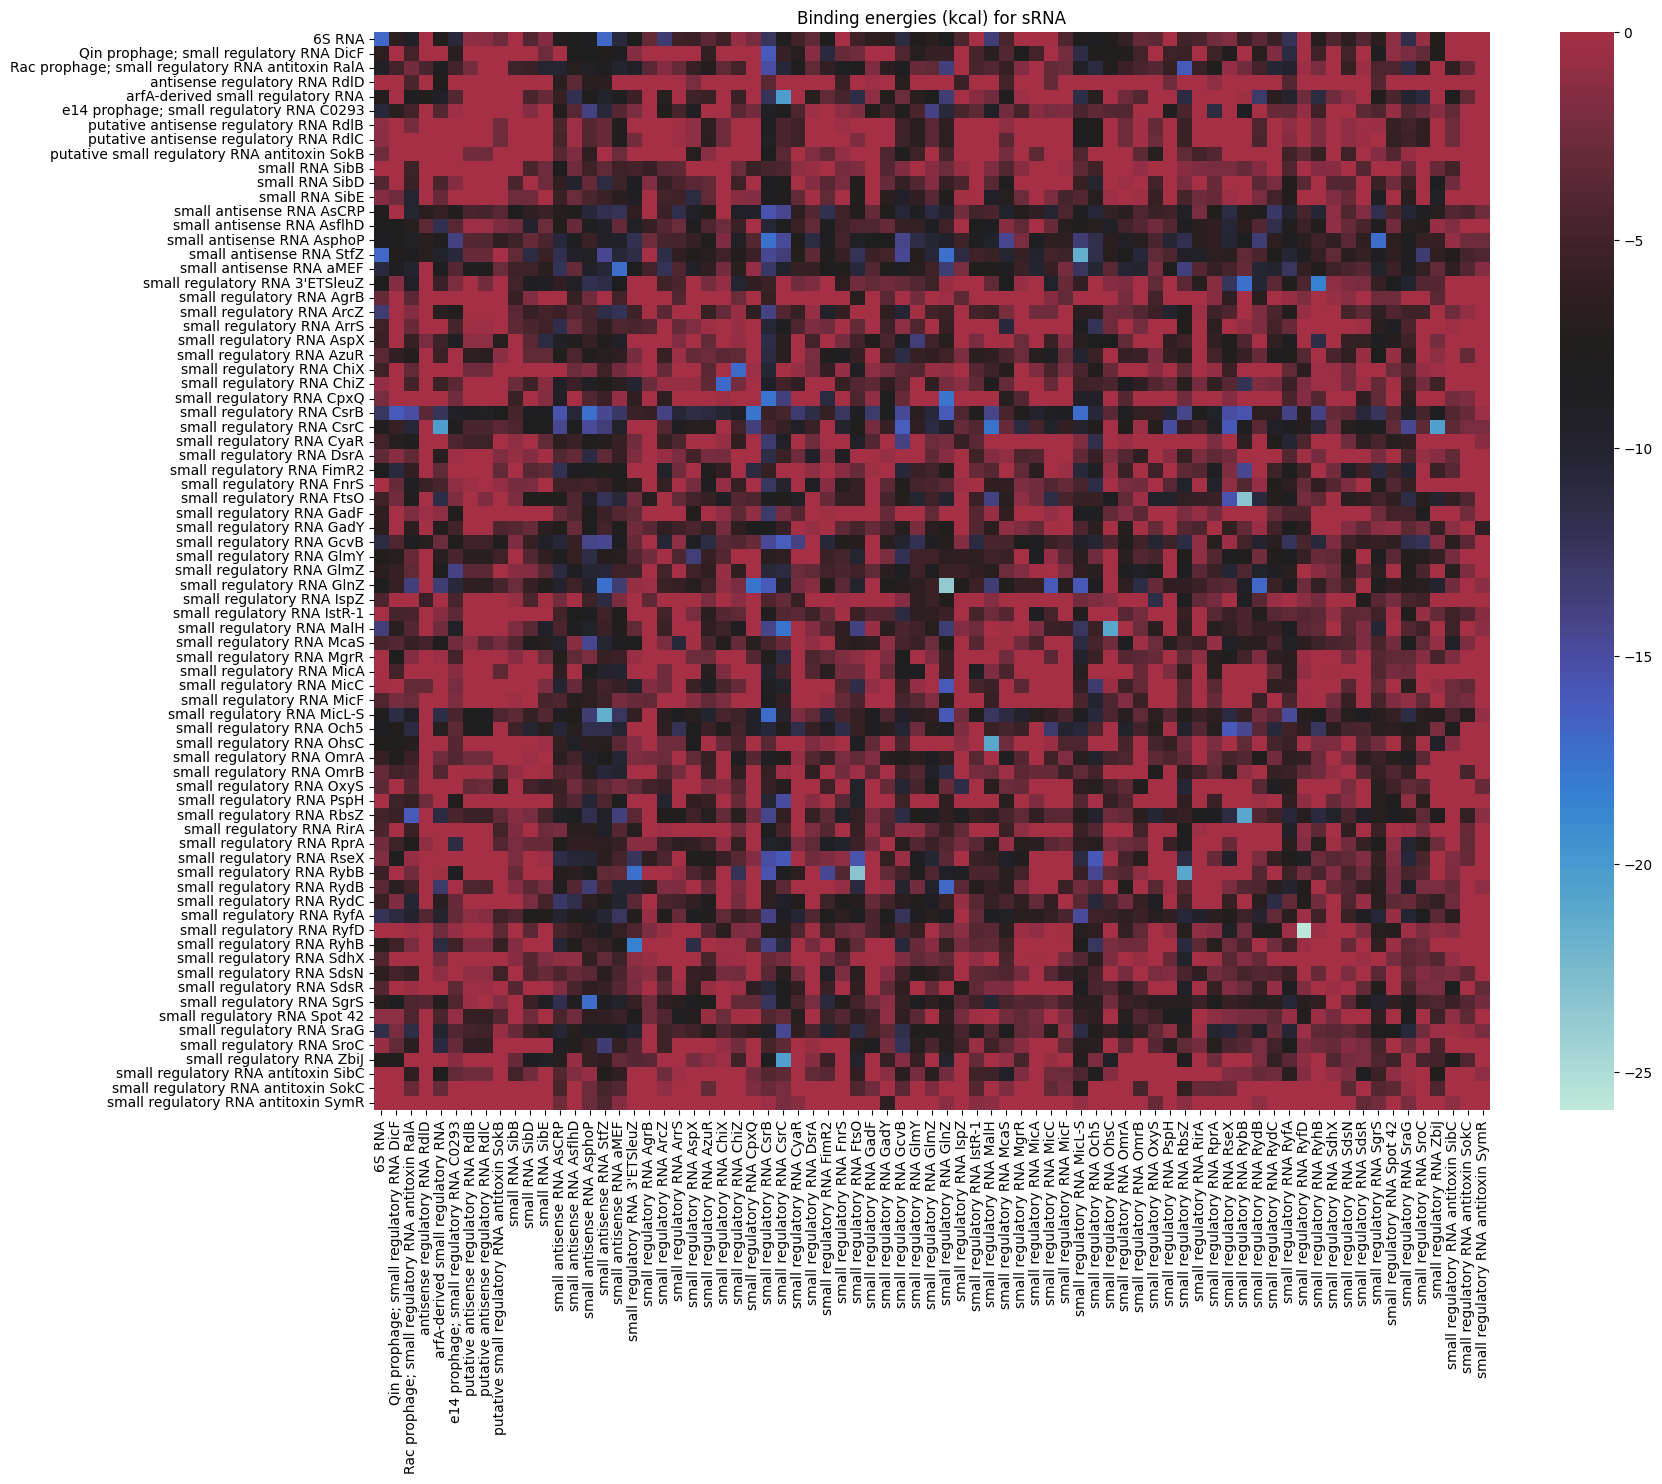

In [17]:
fig = plt.figure(figsize=(18, 14))
sns.heatmap(e,
            xticklabels=sorted(circuit_fasta_d), yticklabels=sorted(circuit_fasta_d),  
            center=-8)  # , yticklabels=energies.columns) # cmap='YlGnBu'
plt.title('Binding energies (kcal) for sRNA')
plt.savefig('data/figs/confusion_sRNA.jpg')

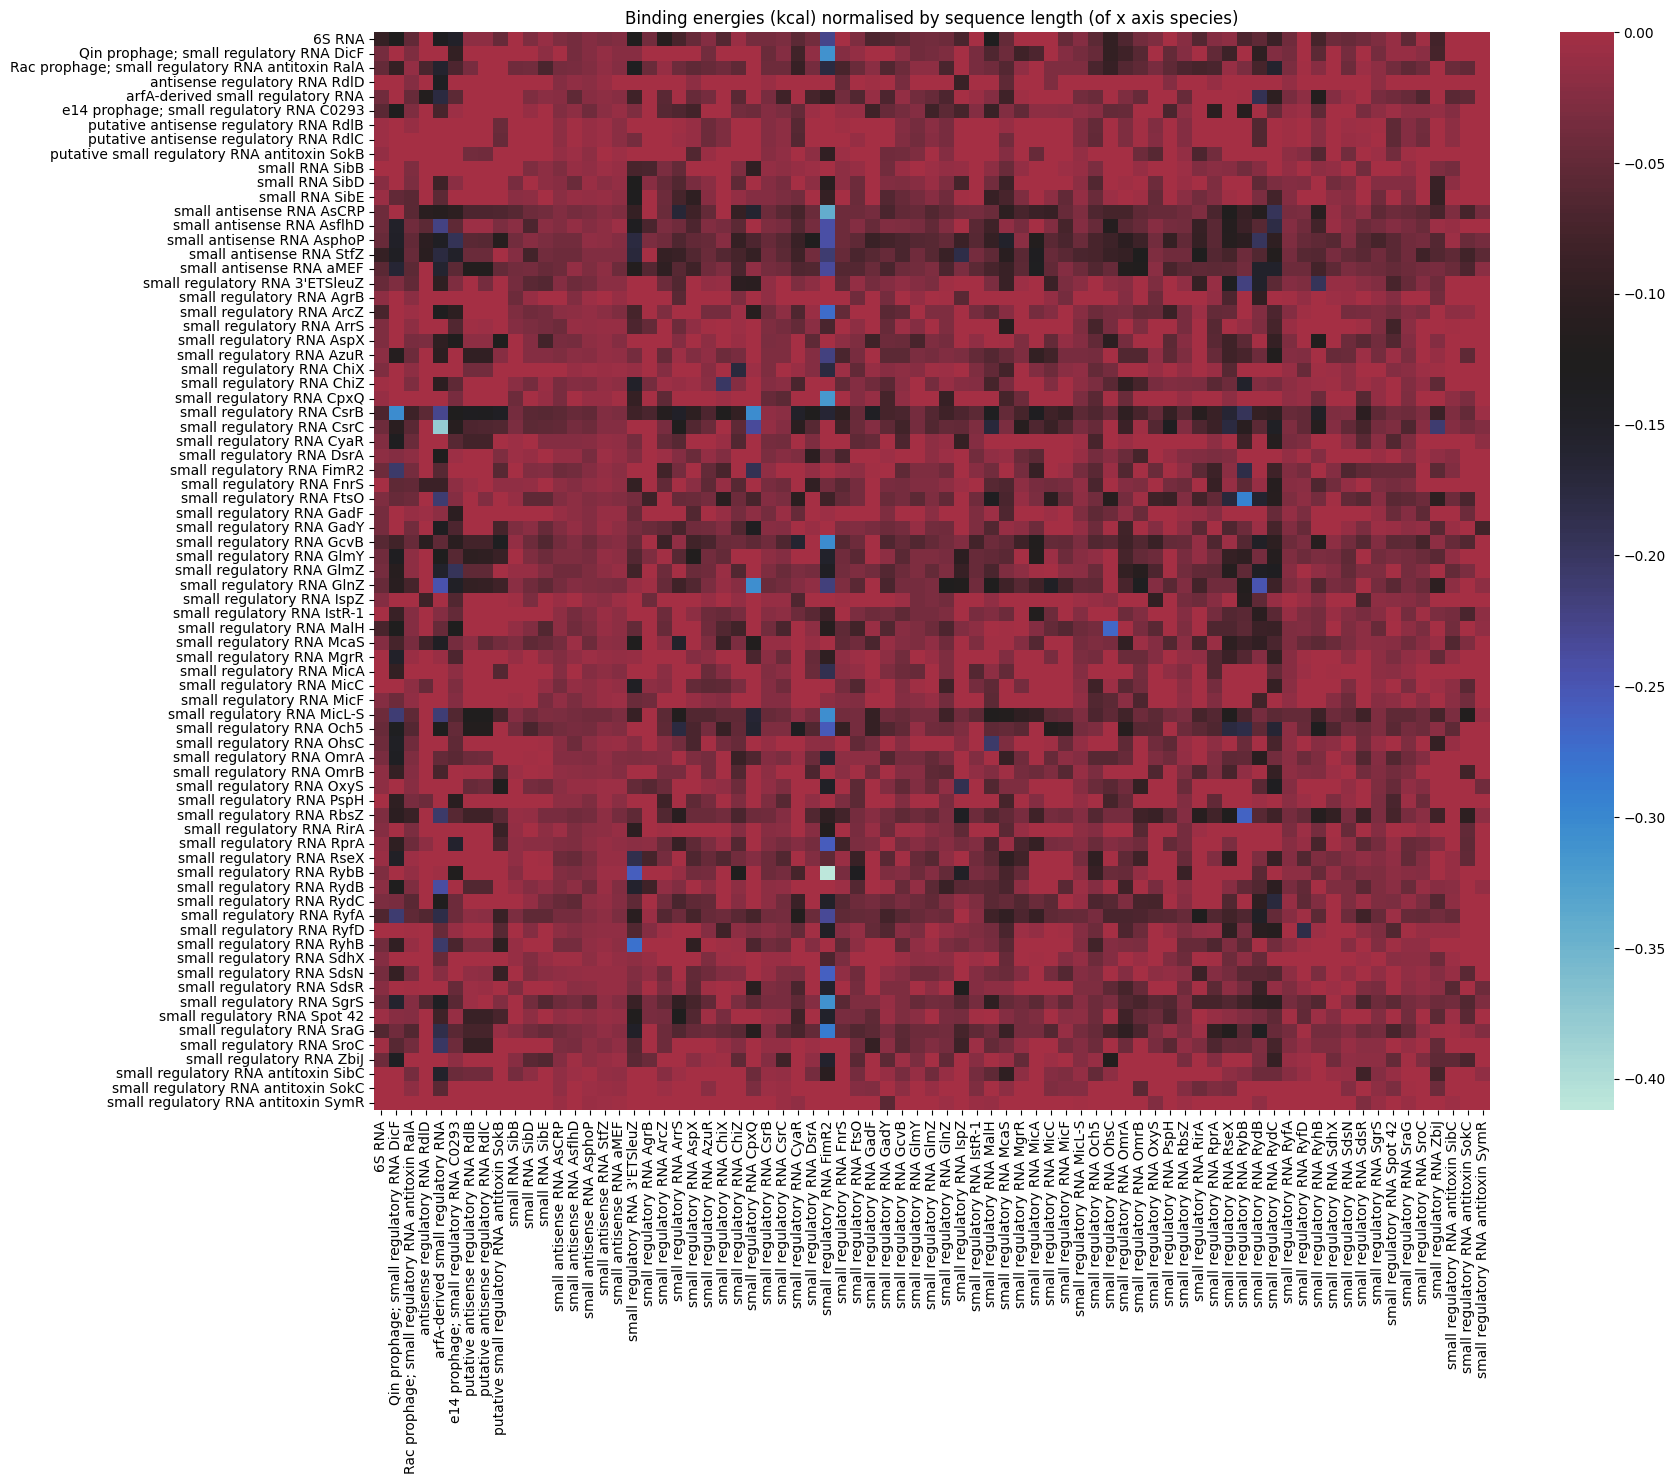

In [18]:
fig = plt.figure(figsize=(18, 14))
sns.heatmap(e_norm,
            xticklabels=sorted(circuit_fasta_d), yticklabels=sorted(circuit_fasta_d),
            center=-8 / e.min() * e_norm.min())  # , yticklabels=energies.columns) # cmap='YlGnBu'
plt.title('Binding energies (kcal) normalised by sequence length (of x axis species)')
plt.savefig('data/figs/confusion_sRNA_norm.jpg')


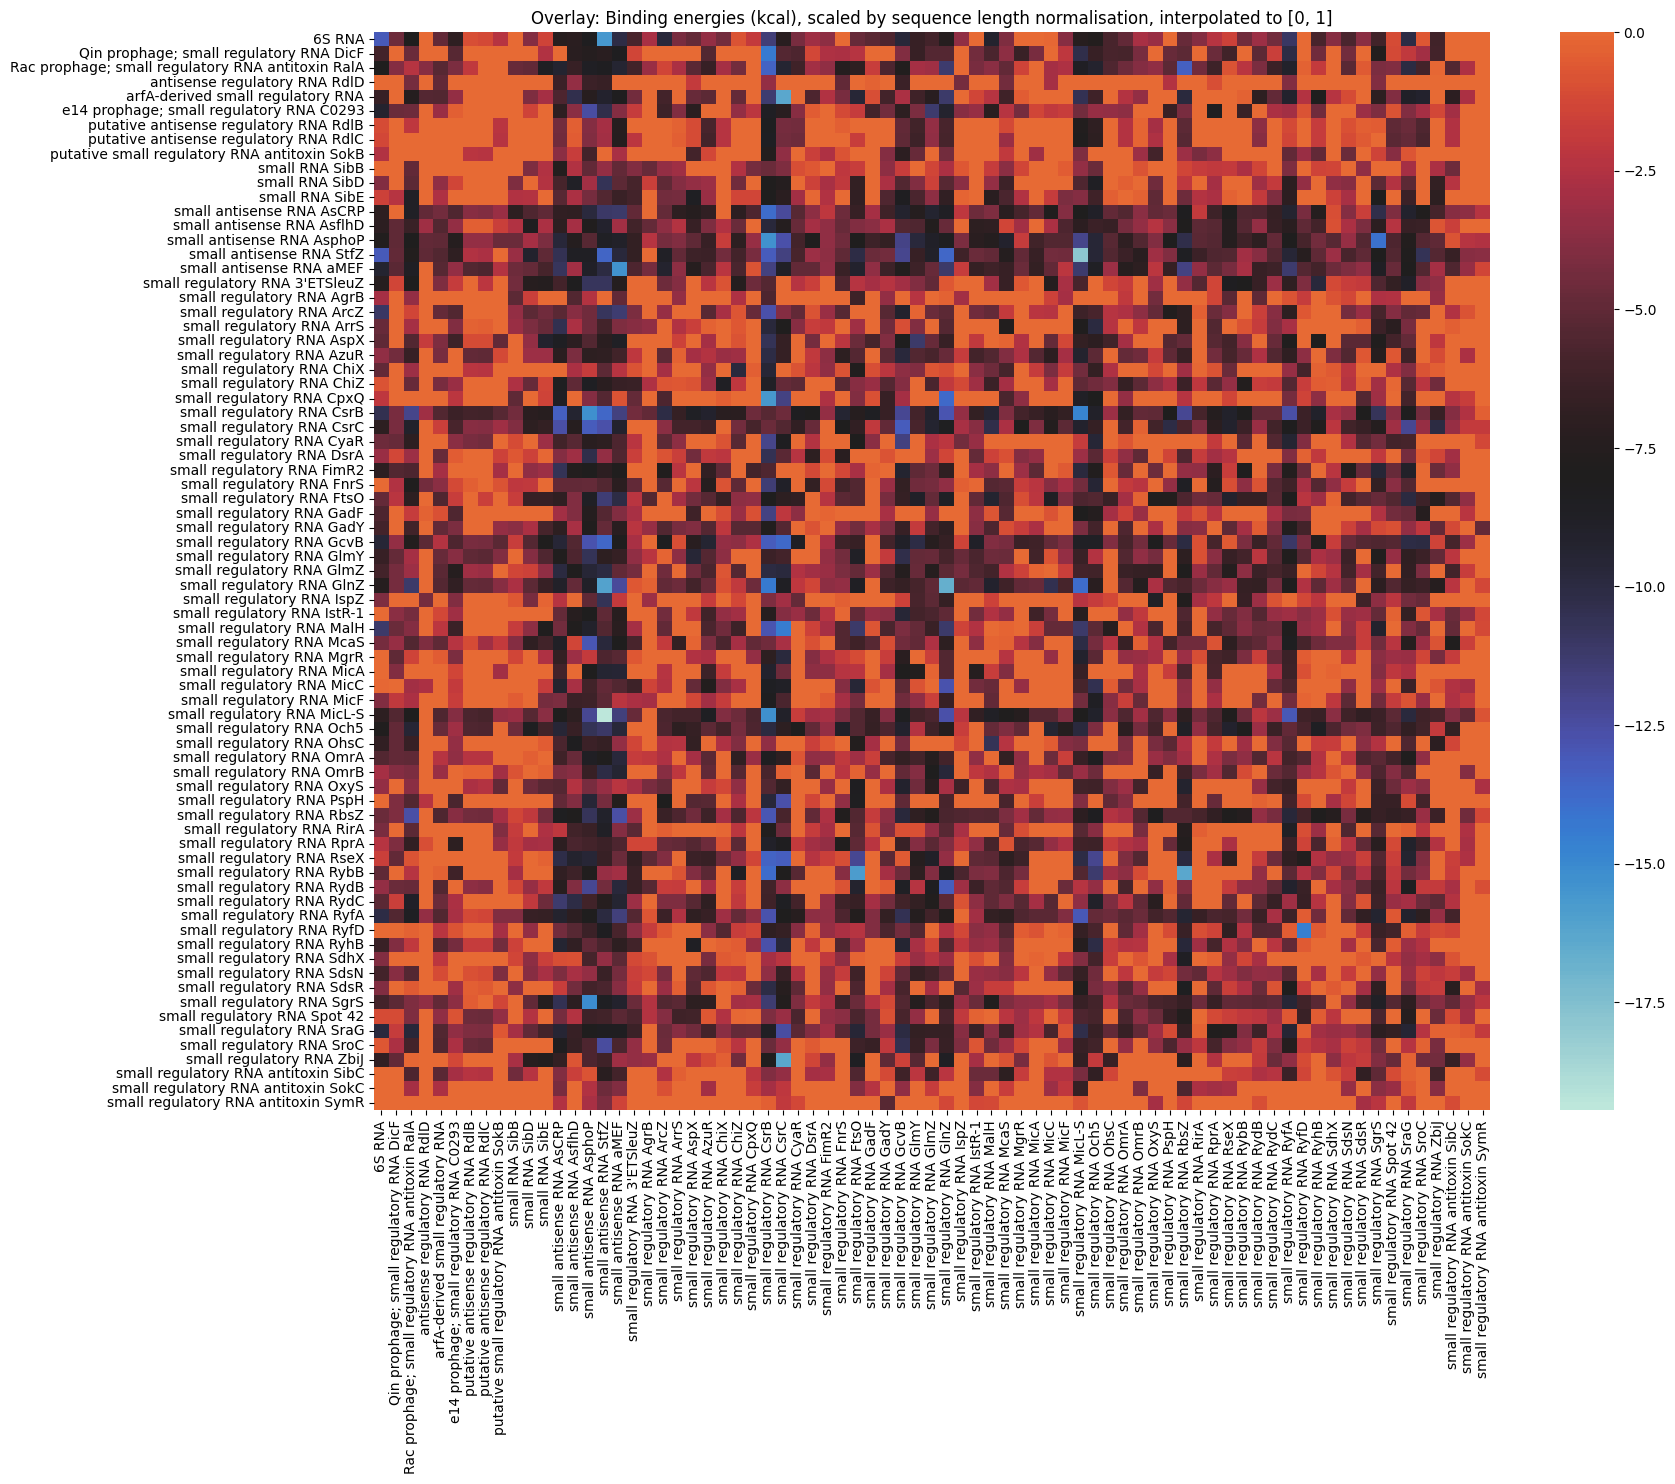

In [19]:
fig = plt.figure(figsize=(18, 14))
sns.heatmap(e * np.interp(e_norm, [e_norm.min(), e_norm.max()], [0, 1]),
            xticklabels=sorted(circuit_fasta_d), yticklabels=sorted(circuit_fasta_d), 
            center = -8)  # , yticklabels=energies.columns) # cmap='YlGnBu'
plt.title('Overlay: Binding energies (kcal), scaled by sequence length normalisation, interpolated to [0, 1]')
plt.savefig('data/figs/confusion_sRNA_len-norm.jpg')


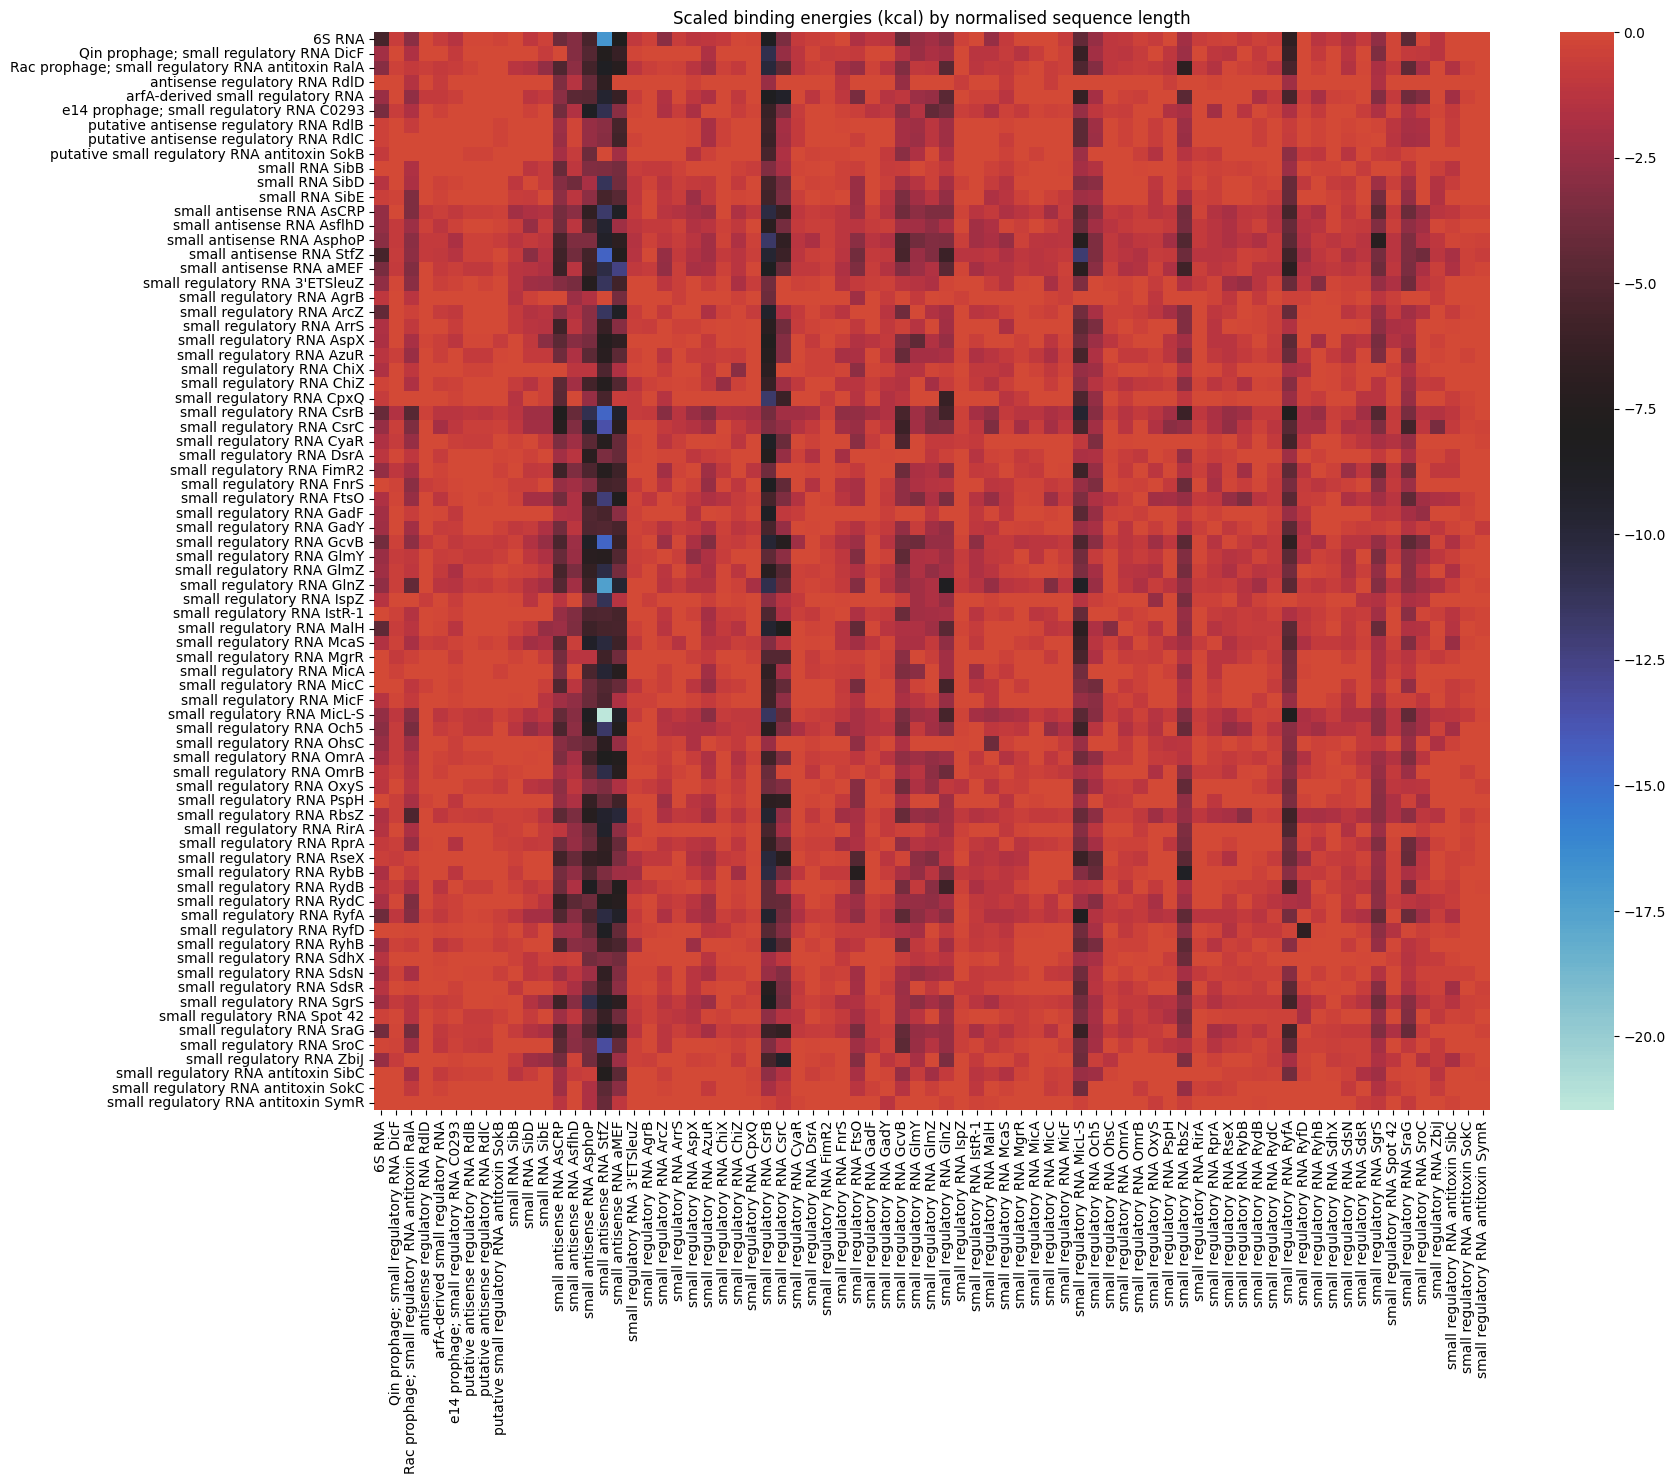

In [20]:
s = (slengths * np.ones_like(e)) / (slengths * np.ones_like(e)).max()

fig = plt.figure(figsize=(18, 14))
sns.heatmap(e * s,
            xticklabels=sorted(circuit_fasta_d), yticklabels=sorted(circuit_fasta_d), 
            center = -8)  # , yticklabels=energies.columns) # cmap='YlGnBu'
plt.title('Scaled binding energies (kcal) by normalised sequence length')

plt.savefig('data/figs/confusion_sRNA_len-norm2.jpg')
